In [1]:
# Importing libraries neeeded for the project
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

In [2]:
#!/usr/bin/env /Applications/MAMP/Library/bin/python

import mysql.connector

config = {
  'user': 'root',
  'password': 'root',
  'host': '127.0.0.1',
  'port': 8889,
  'database': 'ecotourisme',
  'raise_on_warnings': True
}

cnx = mysql.connector.connect(**config)

cursor = cnx.cursor(dictionary=True)

cursor.execute('SELECT pays.nom as pays, s.id_pays, s.annee, s.gpi, t.arriveesTotal as arriveesTotal, t.arriveesAvion, e.pibParHab, eco.co2, eco.GES_hab as gesParHab FROM surete as s, tourisme as t, economie as e, ecologie as eco, pays where pays.id = s.id_pays and s.id_pays = t.id_pays AND t.id_pays = e.id_pays AND e.id_pays = eco.id_pays AND s.annee = t.annee AND t.annee = e.annee AND e.annee = eco.annee AND e.annee=2020;')
results = cursor.fetchall()
 
#cursor.execute('SELECT pays.nom as pays, s.id_pays, AVG(s.gpi) as gpi, AVG(t.arriveesTotal) as arriveesTotal, AVG(t.arriveesAvion) as arriveesAvion, AVG(e.pibParHab) as pibParHab, AVG(eco.co2) as co2 FROM surete as s, tourisme as t, economie as e, ecologie as eco, pays where pays.id = s.id_pays and s.id_pays = t.id_pays AND t.id_pays = e.id_pays AND e.id_pays = eco.id_pays AND s.annee = t.annee AND t.annee = e.annee AND e.annee = eco.annee GROUP BY pays.id;')
#results = cursor.fetchall()
 

data = []
for row in results:
    pays = row['pays']
    id_pays = row['id_pays']
    annee = row['annee']
    gpi = row['gpi']
    arriveesTotal = row['arriveesTotal']
    pibParHab = row['pibParHab']
    gesParHab = row['gesParHab']
    data.append({'pays': pays,'id_pays': id_pays, 'arriveesTotal': arriveesTotal, 'gpi': gpi, 'pibParHab': pibParHab, 'gesParHab': gesParHab})

    #print(id_pays, arriveesTotal, arriveesAvion)

cnx.close()

df = pd.DataFrame(data)

# Normaliser les indicateurs
df['arriveesTotal'] = df['arriveesTotal'] / df['arriveesTotal'].max()
df['gpi'] = df['gpi'].min() / df['gpi']
df['pibParHab'] = df['pibParHab'] / df['pibParHab'].max()
df['gesParHab'] = df['gesParHab'].min() / df['gesParHab']


In [3]:
from sklearn.cluster import KMeans
import numpy as np

# Sélectionner les variables pour le clustering
X = df[['arriveesTotal', 'gpi', 'pibParHab', 'gesParHab']]

# Supprimer les lignes avec des valeurs manquantes et réinitialiser l'index
X = X.dropna().reset_index(drop=True)

# Filtrer df pour correspondre à l'index de X
df = df.loc[X.index]



In [4]:
from sklearn.cluster import SpectralCoclustering
from sklearn.preprocessing import StandardScaler
import numpy as np

# Supposons que vous avez déjà une matrice de données à bicluster, par exemple 'data'
# data doit être une matrice de dimensions (n_samples, n_features)


# Standardiser les données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Créer l'objet de biclustering
model = SpectralCoclustering(n_clusters=5, random_state=42)

# Appliquer le biclustering aux données
model.fit(X)

# ajouter une colonne bicluster dans le DataFrame
df['bicluster'] = model.row_labels_

# Afficher les résultats
print("Bicluster indices:")
print(model.row_labels_)  # Indices des lignes pour les biclusters
print(model.column_labels_)  # Indices des colonnes pour les biclusters

df = df.sort_values(by='bicluster', ascending=False)

df.head(40)


df[df['bicluster'] == 2]

# moyenne des gpi pour chaque bicluster
# moyenne des gpi pour chaque bicluster
df.groupby('bicluster')['pibParHab'].mean()



Bicluster indices:
[2 0 1 2 0 1 1 2 1 0 0 4 2 1 2 2 2 2 0 2 2 1 1 2 3 4 0 2 2 1 0 1 2 2 2 0 3
 1 0 3 1 0 0 1 0 2 0 0 4 3 2 0 2 1 1 3 0 2 1 2 0 0 2 1 1 2 2 4 1 1 0 0 3 2
 0 0 2 2 0 2 4 2 2 2 0 0 1 0 2 1 1 0 0 2 3 2 1 1 1 4 1 1 4 4 2 2 4 0 2 1 0
 4 0 3 2 2 2 2 0]
[3 2 1 4]


bicluster
0    0.185806
1    0.355042
2    0.172226
3    0.105364
4    0.255075
Name: pibParHab, dtype: float64

    arriveesTotal       gpi  pibParHab  gesParHab
2        0.069030  0.545500   0.716018   0.006467
2        0.069030  0.545500   0.716018   0.006467
2        0.069030  0.545500   0.716018   0.006467
2        0.069030  0.545500   0.716018   0.006467
2        0.069030  0.545500   0.716018   0.006467
..            ...       ...        ...        ...
0        0.000546  0.575078   0.063827   0.143873
0        0.000546  0.575078   0.063827   0.143873
0        0.000546  0.575078   0.063827   0.143873
0        0.000546  0.575078   0.063827   0.143873
0        0.000546  0.575078   0.063827   0.143873

[119 rows x 4 columns]


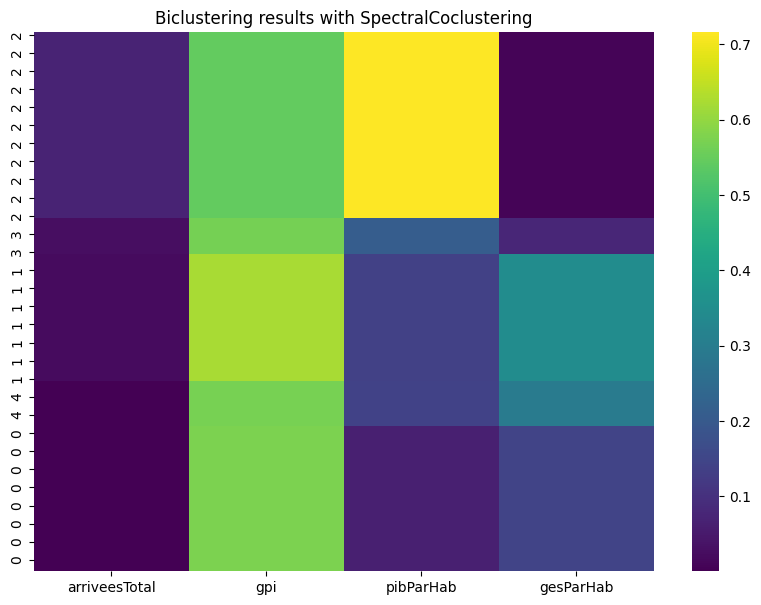

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Obtenir les labels de biclustering
row_labels = model.row_labels_
column_labels = model.column_labels_

# Créer un nouveau DataFrame avec les lignes réorganisées
df_reordered = pd.DataFrame(X.values[row_labels, :], columns=X.columns, index=X.index[row_labels])

# classer les collones en ordre decroissant

df_reordered = df_reordered.sort_values(by='arriveesTotal', ascending=False)

print(df_reordered)

# Créer une carte de chaleur
plt.figure(figsize=(10, 7))
sns.heatmap(df_reordered, cmap='viridis')
plt.title('Biclustering results with SpectralCoclustering')
plt.show()

In [6]:
import plotly.express as px

# Créer un DataFrame avec les colonnes nécessaires
df_plot = df[['pibParHab', 'arriveesTotal', 'bicluster', 'pays', 'gesParHab', 'gpi']]

# Créer un graphique de dispersion interactif
df_plot = df[['pibParHab', 'arriveesTotal', 'bicluster', 'pays', 'gesParHab', 'gpi']]
fig = px.scatter(df_plot, x='pibParHab', y='bicluster', color='bicluster', hover_data=['pays', 'gpi', 'arriveesTotal', 'pibParHab'])

# Afficher le graphique
fig.show()

In [7]:
import pycountry

# Fonction pour convertir ISO-2 en ISO-3
def iso2_to_iso3(iso2):
    try:
        return pycountry.countries.get(alpha_2=iso2).alpha_3
    except AttributeError:
        return np.nan

# Appliquer la fonction à la colonne 'id_pays'
df['id_pays'] = df['id_pays'].apply(iso2_to_iso3)

df.head()

# Créer une carte du monde
fig = px.choropleth(df, locations='id_pays', color='bicluster', hover_name='pays', projection='natural earth')

# Mettre à jour la carte
fig.update_geos(showcountries=True, countrycolor="Black", showland=True, showocean=True, oceancolor="LightBlue", showlakes=True, lakecolor="Blue")

# Afficher la carte
fig.show()
df.head()


,pays,id_pays,arriveesTotal,gpi,pibParHab,gesParHab,bicluster
48,Croatie,HRV,0.184512,0.720444,0.285178,0.199678,4
106,Serbie,SRB,0.003808,0.612778,0.193279,0.111150,4
25,Côte d´Ivoire,CIV,0.005704,0.522007,0.053954,0.387290,4
80,Maurice (Île),MUS,0.002698,0.708869,0.213997,0.147379,4
67,Liban,LBN,0.003535,0.428017,0.145821,0.107703,4


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Supprimer les valeurs manquantes du DataFrame
df = df.dropna(subset=['arriveesTotal',  'gpi', 'gesParHab', 'pibParHab'])

# Séparer les données en variables indépendantes (X) et dépendante (y)
X = df[['arriveesTotal', 'gpi','gesParHab']]  # Variables indépendantes
y = df['pibParHab']  # Variable dépendante


# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Créer le modèle de régression linéaire
model = LinearRegression()

# Entraîner le modèle sur l'ensemble d'entraînement
model.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = model.predict(X_test)

# Calculer l'erreur quadratique moyenne (RMSE) pour évaluer les performances du modèle
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE:", rmse)

# Afficher les coefficients de régression
print("Coefficients:", model.coef_)

# Afficher l'interception
print("Intercept:", model.intercept_)


# En interprétant ces résultats, vous pouvez dire que les variables arriveesTotal et arriveesAvion ont des coefficients
# positifs, ce qui signifie qu'une augmentation du nombre total d'arrivées touristiques et du nombre d'arrivées par avion 
# est associée à une augmentation du PIB par habitant. D'autre part, le coefficient négatif pour la variable gpi indique 
# qu'un GPI (Indice de Puissance Globale) plus élevé est associé à une diminution du PIB par habitant. Les coefficients pour 
# les variables co2 et gesParHab sont également positifs, ce qui suggère qu'une augmentation des émissions de CO2 et des émissions
# de gaz à effet de serre par habitant est associée à une augmentation du PIB par habitant.

# Dans votre cas, le RMSE est de 0.08845969610817209. Sans connaître l'échelle de votre variable dépendante pibParHab, 
# il est difficile de dire si cette valeur est faible ou élevée. Cependant, si pibParHab est normalisé (par exemple, 
# entre 0 et 1), alors un RMSE de 0.088 serait considéré comme relativement faible, ce qui indiquerait que votre modèle 
# fait des prédictions assez précises.


RMSE: 0.1146498341146689
Coefficients: [ 0.40005003  0.86742844 -0.57639446]
Intercept: -0.18666745176984476


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

